In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from Models.CNN import ConvNet
from Models.CNN_LSTM_attention import CNN_LSTM_attention
from Models.CNN_LSTM import CNN_LSTM
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix,
                             roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay)
from collections import OrderedDict

torch.manual_seed(10)

path_dir = '/Users/titouan/Desktop/Coughvid-COVID-Predictor/'

path_img_dir_test = path_dir + "Data/MelSpecs_test"
df_label_test= pd.read_csv(path_dir + "Data/MelSpecs_labels_test.csv")


In [ ]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.iloc[idx]["label"]
        filename = self.df.iloc[idx]["filename"]

        # Read image
        img_path = os.path.join(self.img_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype(np.float32) / 255.0
        img = img.transpose(2, 0, 1)  # Convert (H, W, C) to (C, H, W)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

BATCH_SIZE=256 
test_dataset = MelSpectrogramDataset(df_label_test, path_img_dir_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Get one image to determine input dimensions
sample_img, _ = test_dataset[0]  # First image and label
input_dim = sample_img.shape  # (C, H, W)
print("Input shape:", input_dim)

cpu
Input shape: torch.Size([3, 199, 515])


<All keys matched successfully>

Load models with trained weights

In [ ]:
state_dict = torch.load( path_dir + 
        '/results_CNN/cnn_new_state_augmented_100.pth',
    map_location=torch.device('cpu')
)

# If model was trained with DataParallel
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict[new_key] = v

cnn = ConvNet(input_dim=input_dim)
cnn.load_state_dict(new_state_dict, strict=True)

Test Accuracy: 83.48 %, Precision: 64.83 %, Recall: 74.01 %, F1-Score: 69.11 %, AUC: 80.32 %


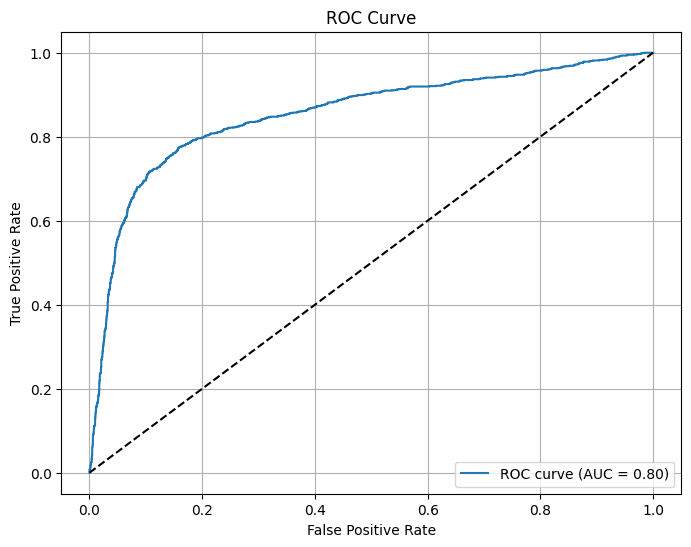

In [ ]:
cnn.eval()

all_labels = []
all_probs = []

correct = 0
total = 0

with torch.no_grad():
    # Collect TEST features and labels
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = cnn(x_batch).squeeze() 
        y_pred_proba = torch.sigmoid(outputs)
        label_predicted = (y_pred_proba >= 0.5).int()

        total += y_batch.size(0)
        correct += (label_predicted == y_batch.int()).sum().item()

        all_labels.append(y_batch.int().cpu())
        all_probs.append(y_pred_proba.cpu())

# Concatenate all batches
all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

# Compute metrics

p=0.5

precision = precision_score(all_labels,(all_probs >= p).astype(int),  average="binary")
recall = recall_score(all_labels,(all_probs >= p).astype(int), average="binary")
f1 = f1_score(all_labels,(all_probs >= p).astype(int), average=None)[1]
auc=roc_auc_score(all_labels,(all_probs >= p).astype(int), average=None)

test_accuracy=correct / total

print('Test Accuracy: {:.2f} %, Precision: {:.2f} %, Recall: {:.2f} %, F1-Score: {:.2f} %, AUC: {:.2f} %'.format(
    test_accuracy * 100, precision * 100, recall * 100, f1 * 100, auc * 100))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('results_CNN/ROC_curve.png')


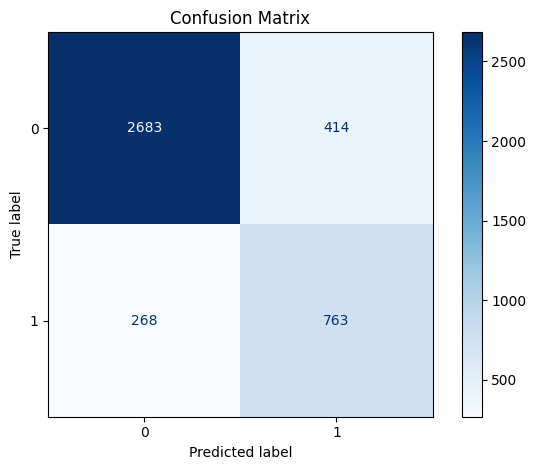

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, (all_probs >= p).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig('results_CNN/Confusion_matrix.png')


In [ ]:
def pr_and_f1_curves(y_true, y_prob):
    """
    Plot precision-recall curve and F1 vs threshold curve.
    """
    # PR data
    prec, rec, thresh = precision_recall_curve(y_true, y_prob)
    prec, rec = prec[:-1], rec[:-1]
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)

    best_idx      = np.argmax(f1)
    best_thr      = thresh[best_idx]
    best_f1       = f1[best_idx]
    avg_prec      = average_precision_score(y_true, y_prob)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))

    # Left: PR curve
    ax[0].plot(rec, prec, color='tab:blue', label=f'PR curve  (AP = {avg_prec:.3f})')
    ax[0].scatter(rec[best_idx], prec[best_idx], color='red', zorder=5,
                  label=f'Best F₁ = {best_f1:.3f}\n@ thr = {best_thr:.2f}')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision–Recall curve')
    ax[0].legend()
    ax[0].grid(True)

    # Right: F1 vs threshold
    ax[1].plot(thresh, f1, color='tab:blue')
    ax[1].scatter(best_thr, best_f1, color='red', zorder=5)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('F₁ score')
    ax[1].set_title('F₁ score vs decision threshold')
    ax[1].grid(True)

    plt.tight_layout()
    plt.savefig('results_CNN/pr_f1.png')
    plt.show()

    return best_thr, best_f1

# Plot precision-recall and F1 vs threshold plots
best_thr, best_f1 = pr_and_f1_curves(all_labels, all_probs)
print(f"Optimal threshold = {best_thr:.3f}  |  Best F1 = {best_f1:.3f}")

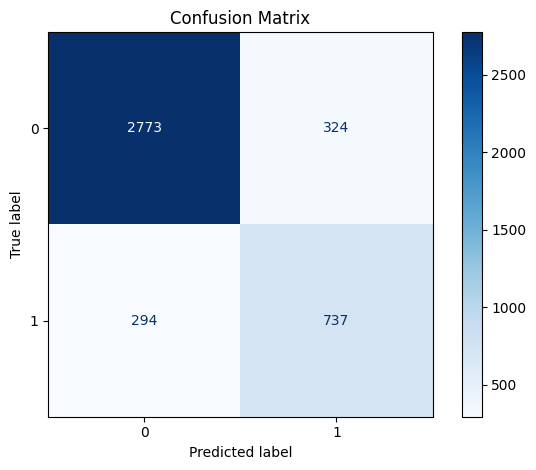

In [ ]:
# Change threshold to maximise F1 score
final_preds = (np.array(all_probs) >= best_thr).astype(int)

# Confusion Matrix
cm = confusion_matrix(all_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig('results_CNN/Confusion_matrix_optimised.png')